In [1]:
# Copyright (c) Nanjing University, Vision Lab.
# Last update: 2019.10.27
# 2019.11.14 D1 hausdorff

# Evaluate R-D performance

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pylab  as plt
import pandas as pd
import subprocess
import configparser
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/py3-mink/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/py3-mink/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/py3-mink/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/py3-mink/lib

In [3]:
from mycodec_factorized import preprocess, postprocess, compress, decompress, \
write_binary_files, read_binary_files

### set GPU/CPU

In [4]:
# os.environ['CUDA_VISIBLE_DEVICES']=""

# set gpu.
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
config.log_device_placement=True
# config.device_count={'gpu':0}
sess = tf.Session(config=config)

### Metrics

In [5]:
from myutils.pc_error_wrapper import pc_error
from myutils.pc_error_wrapper import get_points_number

## Set config

In [6]:
input_file = 'testdata/8iVFB/soldier_vox10_0690.ply'

filename = os.path.split(input_file)[-1][:-4]
output_file = filename + '_rec.ply'
input_file_n = input_file

config_file = os.path.join('./config/factorized/', filename+'.ini')
config = configparser.ConfigParser()
if os.path.exists(config_file):
    config.read(config_file)
    print('config already exists.')
else:
    config["DEFAULT"] = {"cube_size": 64, 
                        "min_num": 64,
                        "resolution":1024}

    config["R1"] = {"scale": 5/8.,
                   "ckpt_dir": './checkpoints/factorized/a2b3/'}

    config["R2"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/factorized/a2b3/'}

    config["R3"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/factorized/a3b3/'}

    config["R4"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/factorized/a3b2/'}

    config["R5"] = {"scale": 1.0,
                   "ckpt_dir": './checkpoints/factorized/a5b2/'}
    config.write(open(config_file, 'w'))
    print('initialize config.')

config already exists.


## Select rho

In [7]:
def select_rho(item, input_file, output_file, input_file_n, 
               cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res):

    steps = [0.02]*4+[0.04]*4+[0.08]*4
    MAX = 0
    rho = 1.0
    optimal_rho = 1.0

    for i, step in enumerate(steps):
        print('===== select rho =====')
        postprocess(output_file, cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, rho)
        results = pc_error(input_file, output_file, input_file_n, res, show=True)
        """
        # record results.
        results["n_points"] = get_points_number(output_file)
        results["rho"] = rho
        if i == 0:
            all_results = results.copy(deep=True)
        else:
            all_results = all_results.append(results, ignore_index=True)
        """

        PSNR = float(results[item])
        print('===== results: ', i, rho, item, PSNR)

        MAX = max(PSNR, MAX)
        if PSNR < MAX:
            break
        else:
            optimal_rho = rho

        if item == "mseF,PSNR (p2point)":
            rho += step
        elif item == "mseF,PSNR (p2plane)":
            rho -= step
        else:
            print('ERROR', item)
            break
    
    return optimal_rho

## Run

In [8]:
# model = 'model_voxception'
import models.model_voxception as model
cube_size = config.getint('DEFAULT', 'cube_size')
min_num = config.getint('DEFAULT', 'min_num')
res = config.getint('DEFAULT', 'resolution')

print('cube size:', cube_size, 'min num:', min_num, 'res:', res)

for index, rate in enumerate(config.sections()):
    scale = float(config.get(rate, 'scale'))
    ckpt_dir = str(config.get(rate, 'ckpt_dir'))
    print('====================', 'config:', rate, 'scale:', scale, 'ckpt_dir:', ckpt_dir)

    # Pre-process
    cubes, cube_positions, points_numbers = preprocess(input_file, scale, cube_size, min_num)
    ### Encoding
    strings, min_v, max_v, shape = compress(cubes, model, ckpt_dir)
    # Write files
    filename = os.path.split(input_file)[-1][:-4]
    print(filename)
    rootdir = './compressed/'
    bytes_strings, bytes_pointnums, bytes_cubepos = write_binary_files(
        filename, strings.numpy(), points_numbers, cube_positions,
        min_v.numpy(), max_v.numpy(), shape.numpy(), rootdir)
    # Read files
    strings_d, points_numbers_d, cube_positions_d, min_v_d, max_v_d, shape_d = \
    read_binary_files(filename, rootdir)
    # Decoding
    cubes_d = decompress(strings_d, min_v_d, max_v_d, shape_d, model, ckpt_dir)

    # bpp
    N = get_points_number(input_file)
    bpp = round(8*(bytes_strings + bytes_pointnums + bytes_cubepos)/float(N), 4)
    bpp_strings = round(8*bytes_strings/float(N), 4)
    bpp_pointsnums = round(8*bytes_pointnums/float(N) ,4)
    bpp_cubepos = round(8*bytes_cubepos/float(N), 4)
    
    ########## Post-process ##########
    # select rho for optimal d1/d2 metrics.
    if config.has_option(rate, 'rho_d1'):
        rho_d1 = float(config.get(rate, 'rho_d1'))
    else:
        rho_d1 = select_rho("mseF,PSNR (p2point)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)
        config.set(rate, 'rho_d1', str(rho_d1)) 
        config.write(open(config_file, 'w'))

    if config.has_option(rate, 'rho_d2'):
        rho_d2 = float(config.get(rate, 'rho_d2'))
    else:
        rho_d2 = select_rho("mseF,PSNR (p2plane)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)
        config.set(rate, 'rho_d2', str(rho_d2))
        config.write(open(config_file, 'w'))
    
    # metrics.
    for index_rho, rho in enumerate((1.0, rho_d1, rho_d2)):
        postprocess(output_file, cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, rho)

        # distortion
        results = pc_error(input_file, output_file, input_file_n, res, show=False)
        
        # bpp
        results["n_points"] = get_points_number(output_file)
        results["rho"] = rho
        results["ori_points"] = N
        results["scale"] = scale
        results["bpp_strings"] = bpp_strings
        results["bpp_pointsnums"] = bpp_pointsnums
        results["bpp_cubepos"] = bpp_cubepos
        results["bpp"] = bpp
        
        print(results)
        
        if index_rho == 0:
            if index == 0:
                all_results = results.copy(deep=True)
            else:
                all_results = all_results.append(results, ignore_index=True)
        elif index_rho == 1:
            if index == 0:
                all_results_d1 = results.copy(deep=True)
            else:
                all_results_d1 = all_results_d1.append(results, ignore_index=True)
        else:
            if index == 0:
                all_results_d2 = results.copy(deep=True)
            else:
                all_results_d2 = all_results_d2.append(results, ignore_index=True)    

# write to csv
print(all_results)
print(all_results_d1)
print(all_results_d2)
csv_root_dir = './CSV/factorized/'
if not os.path.exists(csv_root_dir):
    os.makedirs(csv_root_dir)

csv_name = os.path.join(csv_root_dir, filename + '.csv')
all_results.to_csv(csv_name, index=False)

csv_name_d1 = os.path.join(csv_root_dir, filename + '_d1.csv')
all_results_d1.to_csv(csv_name_d1, index=False)

csv_name_d2 = os.path.join(csv_root_dir, filename + '_d2.csv')
all_results_d2.to_csv(csv_name_d2, index=False)

cube size: 64 min num: 64 res: 1024
==================== config: R1 scale: 0.625 ckpt_dir: ./checkpoints/factorized/a2b3/
===== Preprocess =====
Scaling: 3.8628s
Partition: 5.5731s
Voxelization: 0.0663s
cubes shape: (95, 64, 64, 64, 1)
points numbers (sum/mean/max/min): 460624 4849.0 13518 76
===== Compress =====
Instructions for updating:
Colocations handled automatically by placer.
Analysis Transform: 3.5517s
Entropy Encode: 0.0646s
soldier_vox10_0690
===== Write binary files =====
Total file size (Bytes): 8459
Strings (Bytes): 8198
Numbers of points (Bytes): 190
Positions of cubes (Bytes): 71
===== Read binary files =====
===== Decompress =====
Entropy Decode: 0.0777s
Synthesis Transform: 3.1186s
===== Post process =====
Classify and extract points: 0.2288s
Write point cloud to soldier_vox10_0690_rec.ply: 3.7995s
===== measure PCC quality using `pc_error` version 0.13.4 20.9464
   mse1      (p2point)  mse1,PSNR (p2point)  mse1      (p2plane)  \
0              1.52355              63

Classify and extract points: 2.786s
Write point cloud to soldier_vox10_0690_rec.ply: 5.6853s
===== measure PCC quality using `pc_error` version 0.13.4 31.5359
   mse1      (p2point)  mse1,PSNR (p2point)  mse1      (p2plane)  \
0             0.343555              69.6088             0.121697   

   mse1,PSNR (p2plane)  h.       1(p2point)  h.,PSNR  1(p2point)  \
0              74.1159                 62.0              47.0448   

   h.       1(p2plane)  h.,PSNR  1(p2plane)  mse2      (p2point)  \
0              10.7885              54.6391             0.323195   

   mse2,PSNR (p2point)  ...  h.        (p2plane)  h.,PSNR   (p2plane)  \
0              69.8741  ...              256.133              40.8841   

   n_points   rho  ori_points  scale  bpp_strings  bpp_pointsnums  \
0   1142842  1.05     1089091    1.0       0.1562          0.0038   

   bpp_cubepos     bpp  
0       0.0008  0.1608  

[1 rows x 32 columns]
===== Post process =====
Classify and extract points: 0.8683s
Write poi

In [9]:
all_results

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,h. (p2plane),"h.,PSNR (p2plane)",n_points,rho,ori_points,scale,bpp_strings,bpp_pointsnums,bpp_cubepos,bpp
0,1.523550,63.1402,0.421730,68.7184,316.64,39.9631,28.6119,50.4033,1.016010,64.8997,...,178.4710,42.4531,460529,1.0,1089091,0.625,0.0602,0.0014,0.0005,0.0621
1,0.499332,67.9848,0.154122,73.0901,149.00,43.2369,17.2289,52.6061,0.327878,69.8116,...,141.1470,43.4720,1088534,1.0,1089091,1.000,0.1294,0.0038,0.0008,0.1340
2,0.390494,69.0526,0.132457,73.7480,69.00,46.5802,10.3999,54.7985,0.304973,70.1261,...,250.5180,40.9803,1088534,1.0,1089091,1.000,0.1562,0.0038,0.0008,0.1608
3,0.327715,69.8138,0.092027,75.3296,273.00,40.6071,9.0000,55.4263,0.217278,71.5986,...,29.8859,50.2141,1088534,1.0,1089091,1.000,0.2337,0.0038,0.0008,0.2384
4,0.213611,71.6725,0.071229,76.4421,126.00,43.9650,9.0000,55.4263,0.175591,72.5237,...,9.0000,55.4263,1088533,1.0,1089091,1.000,0.3198,0.0038,0.0008,0.3244


In [10]:
all_results_d1

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,h. (p2plane),"h.,PSNR (p2plane)",n_points,rho,ori_points,scale,bpp_strings,bpp_pointsnums,bpp_cubepos,bpp
0,1.204840,64.1594,0.356589,69.4470,297.92,40.2277,27.11090,50.6373,1.190490,64.2115,...,178.4710,42.4531,552615,1.20,1089091,0.625,0.0602,0.0014,0.0005,0.0621
1,0.359252,69.4147,0.119379,74.1995,117.00,44.2869,15.93080,52.9464,0.380783,69.1619,...,428.5650,38.6486,1251723,1.15,1089091,1.000,0.1294,0.0038,0.0008,0.1340
2,0.343555,69.6088,0.121697,74.1159,62.00,47.0448,10.78850,54.6391,0.323195,69.8741,...,256.1330,40.8841,1142842,1.05,1089091,1.000,0.1562,0.0038,0.0008,0.1608
3,0.260316,70.8137,0.072812,76.3467,261.00,40.8023,9.11626,55.3706,0.249330,71.0010,...,36.0008,49.4056,1197304,1.10,1089091,1.000,0.2337,0.0038,0.0008,0.2384
4,0.182213,72.3629,0.062214,77.0299,125.00,43.9996,9.00000,55.4263,0.192407,72.1265,...,9.0000,55.4263,1142842,1.05,1089091,1.000,0.3198,0.0038,0.0008,0.3244


In [11]:
all_results_d2

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,h. (p2plane),"h.,PSNR (p2plane)",n_points,rho,ori_points,scale,bpp_strings,bpp_pointsnums,bpp_cubepos,bpp
0,2.722840,60.6185,0.547322,67.5863,353.76,39.4816,59.10790,47.2523,0.805893,65.9060,...,114.09900,44.3959,322297,0.70,1089091,0.625,0.0602,0.0014,0.0005,0.0621
1,0.557301,67.5078,0.166671,72.7501,171.00,42.6388,21.97300,51.5498,0.311800,70.0300,...,132.11100,43.7593,1033973,0.95,1089091,1.000,0.1294,0.0038,0.0008,0.1340
2,0.506124,67.9262,0.153645,73.1035,86.00,45.6237,9.81761,55.0487,0.273781,70.5947,...,250.51800,40.9803,979532,0.90,1089091,1.000,0.1562,0.0038,0.0008,0.1608
3,0.369976,69.2870,0.102168,74.8756,275.00,40.5754,9.35623,55.2577,0.202170,71.9116,...,29.88590,50.2141,1033973,0.95,1089091,1.000,0.2337,0.0038,0.0008,0.2384
4,0.252561,70.9451,0.080875,75.8906,136.00,43.6333,9.17689,55.3418,0.159970,72.9283,...,9.17689,55.3418,1033973,0.95,1089091,1.000,0.3198,0.0038,0.0008,0.3244


### Plot performance

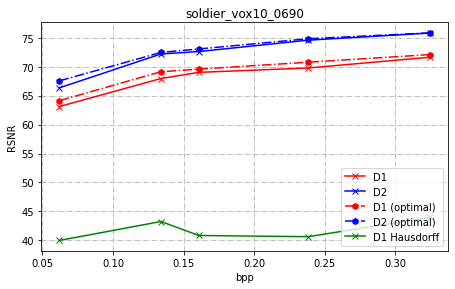

In [12]:
fig, ax = plt.subplots(figsize=(7.3, 4.2))

plt.plot(np.array(all_results["bpp"][:]), np.array(all_results["mseF,PSNR (p2point)"][:]), 
        label="D1", marker='x', color='red')
plt.plot(np.array(all_results["bpp"][:]), np.array(all_results["mseF,PSNR (p2plane)"][:]), 
        label="D2", marker='x', color = 'blue')

plt.plot(np.array(all_results_d1["bpp"][:]), np.array(all_results_d1["mseF,PSNR (p2point)"][:]), 
        label="D1 (optimal)", marker='h', color='red', linestyle='-.')
plt.plot(np.array(all_results_d2["bpp"][:]), np.array(all_results_d2["mseF,PSNR (p2plane)"][:]), 
        label="D2 (optimal)", marker='h', color='blue', linestyle='-.')

plt.plot(np.array(all_results["bpp"][:]), np.array(all_results["h.,PSNR   (p2point)"][:]), 
        label="D1 Hausdorff", marker='x', color = 'green')

plt.title(filename)
plt.xlabel('bpp')
plt.ylabel('RSNR')
plt.grid(ls='-.')
plt.legend(loc='lower right')

fig.savefig(os.path.join(csv_root_dir, filename+'.png'))